In [2]:
# ! pip install numpy

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from prophet import Prophet

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# 1) Synthetic time series 생성 (changepoint + monthly seasonality + noise)
np.random.seed(42)
length = 200
dates = pd.date_range('2020-01-01', periods=length, freq='D')
t = np.arange(length)
trend = np.piecewise(
    t,
    [t < 60, (t >= 60) & (t < 130), t >= 130],
    [lambda x: 0.2 * x,
     lambda x: 0.2 * 60 + 0.5 * (x - 60),
     lambda x: 0.2 * 60 + 0.5 * 70 - 0.1 * (x - 130)]
)
season = 5 * np.sin(2 * np.pi * t / 30)
noise  = np.random.normal(0, 1, size=length)
y = trend + season + noise

# 학습/테스트 분할
train_len = 150
y_train, y_test = y[:train_len], y[train_len:]
dates_train = dates[:train_len]
dates_test  = dates[train_len:]

<Axes: >

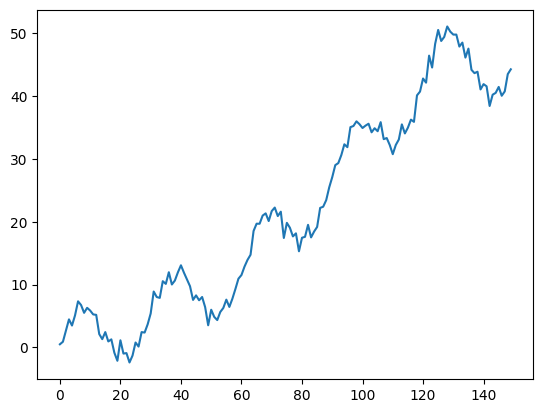

In [12]:
df_train['y'].plot()

In [13]:
# ================================
# 2) Prophet 으로 추세+계절성 모델링
# ================================
# Prophet이 요구하는 포맷(ds, y)으로 DataFrame 생성
df_train = pd.DataFrame({
    'ds': dates_train,
    'y':  y_train
})

# 모델 초기화: 월간 계절성 추가, 기본 주간/연간 계절성은 그대로 사용
m = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False
)
m.add_seasonality(name='monthly', period=20.5, fourier_order=5)

# 학습
m.fit(df_train)

# 전체 기간에 대한 예측용 DataFrame
df_all = pd.DataFrame({'ds': dates})

# 예측
forecast = m.predict(df_all)
base_pred_all = forecast['yhat'].values         # 길이 200
base_pred_train = base_pred_all[:train_len]     # 학습 구간 예측
base_pred_test  = base_pred_all[train_len:]     # 테스트 구간 예측

06:55:33 - cmdstanpy - INFO - Chain [1] start processing
06:55:33 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# 3) 잔차(residual) 계산
residual_train = y_train - base_pred_train      # 길이 150

# 以下 원본과 동일: LSTM 데이터셋 준비, 모델 정의, 학습, 예측 등
def create_dataset(series, window):
    Xs, Ys = [], []
    for i in range(len(series) - window):
        Xs.append(series[i:i+window])
        Ys.append(series[i+window])
    return np.array(Xs), np.array(Ys)

window = 30
X_raw, Y_raw = create_dataset(y_train, window)
X_res,  Y_res  = create_dataset(residual_train, window)

def to_loader(X, Y, batch_size=16):
    X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
    Y_t = torch.tensor(Y, dtype=torch.float32).unsqueeze(-1)
    return DataLoader(TensorDataset(X_t, Y_t), batch_size=batch_size, shuffle=True)

loader_raw = to_loader(X_raw, Y_raw)
loader_res = to_loader(X_res,  Y_res)

class LSTMModel(nn.Module):
    def __init__(self, hidden_size=16):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc   = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [15]:
# 단순 LSTM 학습
model_raw = LSTMModel()
opt_raw   = torch.optim.Adam(model_raw.parameters(), lr=0.01)
loss_fn   = nn.MSELoss()
for epoch in range(100):
    for xb, yb in loader_raw:
        opt_raw.zero_grad()
        loss_fn(model_raw(xb), yb).backward()
        opt_raw.step()

In [16]:
# Residual LSTM 학습
model_res = LSTMModel()
opt_res   = torch.optim.Adam(model_res.parameters(), lr=0.01)
for epoch in range(100):
    for xb, yb in loader_res:
        opt_res.zero_grad()
        loss_fn(model_res(xb), yb).backward()
        opt_res.step()

In [17]:
# 테스트 구간 예측
# 8a) Simple LSTM 예측
simple_preds = []
seq = y_train.copy()
for _ in range(len(y_test)):
    xin = torch.tensor(seq[-window:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    with torch.no_grad():
        p = model_raw(xin).item()
    simple_preds.append(p)
    seq = np.append(seq, p)

In [18]:
# 8b) Hybrid: residual LSTM + Prophet 예측 결합
res_preds = []
seq_res   = residual_train.copy()
for _ in range(len(y_test)):
    xin = torch.tensor(seq_res[-window:], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    with torch.no_grad():
        p = model_res(xin).item()
    res_preds.append(p)
    seq_res = np.append(seq_res, p)

hybrid_preds = base_pred_test + np.array(res_preds)

MSE Simple LSTM   : 16.916
MSE Hybrid L+Prophet: 393.540


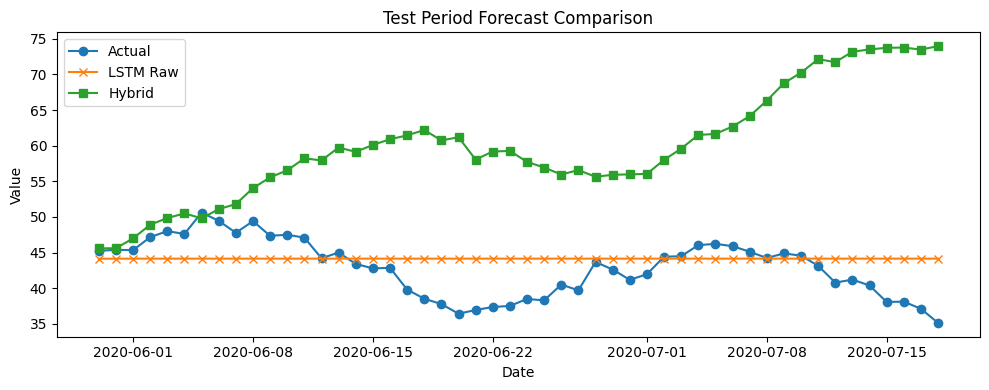

In [19]:
# 9) 성능 비교 (MSE)
mse_simple = np.mean((y_test - simple_preds)**2)
mse_hybrid = np.mean((y_test - hybrid_preds)**2)
print(f"MSE Simple LSTM   : {mse_simple:.3f}")
print(f"MSE Hybrid L+Prophet: {mse_hybrid:.3f}")

# 10) 결과 시각화
plt.figure(figsize=(10,4))
plt.plot(dates_test, y_test,      label='Actual',   marker='o')
plt.plot(dates_test, simple_preds, label='LSTM Raw', marker='x')
plt.plot(dates_test, hybrid_preds, label='Hybrid',   marker='s')
plt.legend()
plt.title("Test Period Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Value")
plt.tight_layout()
plt.show()